In [16]:
from SALib.analyze import sobol as sobolanalyze
import configparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [17]:
plt.rc('figure', figsize=[15, 7])
plt.rc('axes', axisbelow=True)

In [18]:
!pwd

/bg/data/biogeo/users/weber-c/spotpy-ldndc/ldndc_sensitivity


In [19]:
config = configparser.ConfigParser()
config.read('SALib.cfg')
par_ranges = config.get('SALib_SETUP', 'SALib_path_par_ranges')
treat_name = config.get('SITE', 'treat_name')
path = config.get('SITE', 'path_to_site')
site = path.split('/')[-1]
ldndc_output_file = config.get('LDNDC_SETUP', 'ldndc_output_file')
parameter_values = np.loadtxt('../SALib_parameter_values.txt', float)

#Number of of processors SALib was run on
nprocs = 16

In [20]:
print(len(parameter_values))

8192


In [21]:
#Define problem
df_parameters = pd.read_csv(f'../{par_ranges}', sep='\t')

problem = {
    'num_vars': len(df_parameters),
    'names': df_parameters['name'],
    'bounds': [[df_parameters[df_parameters['name'] == para]['min'].values[0], df_parameters[df_parameters['name'] == para]['max'].values[0]] for para in df_parameters['name']]
}

In [22]:
#Catch outputs in correct order
i = 0
proc_runs = np.split(parameter_values, np.arange(len(parameter_values) // nprocs, len(parameter_values) // nprocs * nprocs, len(parameter_values) // nprocs))
Y = np.tile(np.nan, len(parameter_values))

sc_out = pd.read_csv(f'../{path}/{site}_SALib_output/{site}_SALib_{ldndc_output_file}', sep='\t')
sc_out = sc_out.dropna()
sc_out['nproc'] = [int(index.split('_')[0]) for index in sc_out['run_index']]
sc_out['run'] = [int(index.split('_')[1]) for index in sc_out['run_index']]

fill = sc_out.groupby('run_index').sum()['aN_n2o_emis[kgNha-1]'].mean()

for n in range(nprocs):
    
    sc_out_proc = sc_out[sc_out['nproc'] == n]
    
    for run in range(len(proc_runs[n])):
        
        sc_out_proc_run = sc_out_proc[sc_out_proc['run'] == run]
        cum_n2o = sc_out_proc_run['aN_n2o_emis[kgNha-1]'].sum()
        print(f'Y[{i}]; rank = {n}; run = {run}; cum_n2o = {cum_n2o}')
        
        if sc_out_proc_run.size == 0:
            print(f'No output for {n}_{run}')
            Y[i] = fill
        
        else:
            Y[i] = cum_n2o
        
        i += 1

/tmp/ipykernel_1252175/260055289.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fill = sc_out.groupby('run_index').sum()['aN_n2o_emis[kgNha-1]'].mean()


Y[0]; rank = 0; run = 0; cum_n2o = 1.494113
Y[1]; rank = 0; run = 1; cum_n2o = 1.344871
Y[2]; rank = 0; run = 2; cum_n2o = 1.3670149999999999
Y[3]; rank = 0; run = 3; cum_n2o = 1.517861
Y[4]; rank = 0; run = 4; cum_n2o = 1.391206
Y[5]; rank = 0; run = 5; cum_n2o = 1.369953
Y[6]; rank = 0; run = 6; cum_n2o = 1.271486
Y[7]; rank = 0; run = 7; cum_n2o = 1.295552
Y[8]; rank = 0; run = 8; cum_n2o = 0.7382299999999999
Y[9]; rank = 0; run = 9; cum_n2o = 0.735637
Y[10]; rank = 0; run = 10; cum_n2o = 0.589099
Y[11]; rank = 0; run = 11; cum_n2o = 0.783
Y[12]; rank = 0; run = 12; cum_n2o = 0.6321640000000001
Y[13]; rank = 0; run = 13; cum_n2o = 0.779047
Y[14]; rank = 0; run = 14; cum_n2o = 0.588434
Y[15]; rank = 0; run = 15; cum_n2o = 0.631792
Y[16]; rank = 0; run = 16; cum_n2o = 0.83884
Y[17]; rank = 0; run = 17; cum_n2o = 1.6163310000000002
Y[18]; rank = 0; run = 18; cum_n2o = 0.854799
Y[19]; rank = 0; run = 19; cum_n2o = 0.744604
Y[20]; rank = 0; run = 20; cum_n2o = 0.7605459999999999
Y[21]; r

In [9]:
np.savetxt('SALib_results.txt', Y)

In [23]:
#Check for empty outputs
(np.isnan(Y)).any()

#Fill empty outputs
#fill = Y.mean()
#Y = np.nan_to_num(Y, nan=fill)

False

In [24]:
len(pd.unique(sc_out['run_index']))

8192

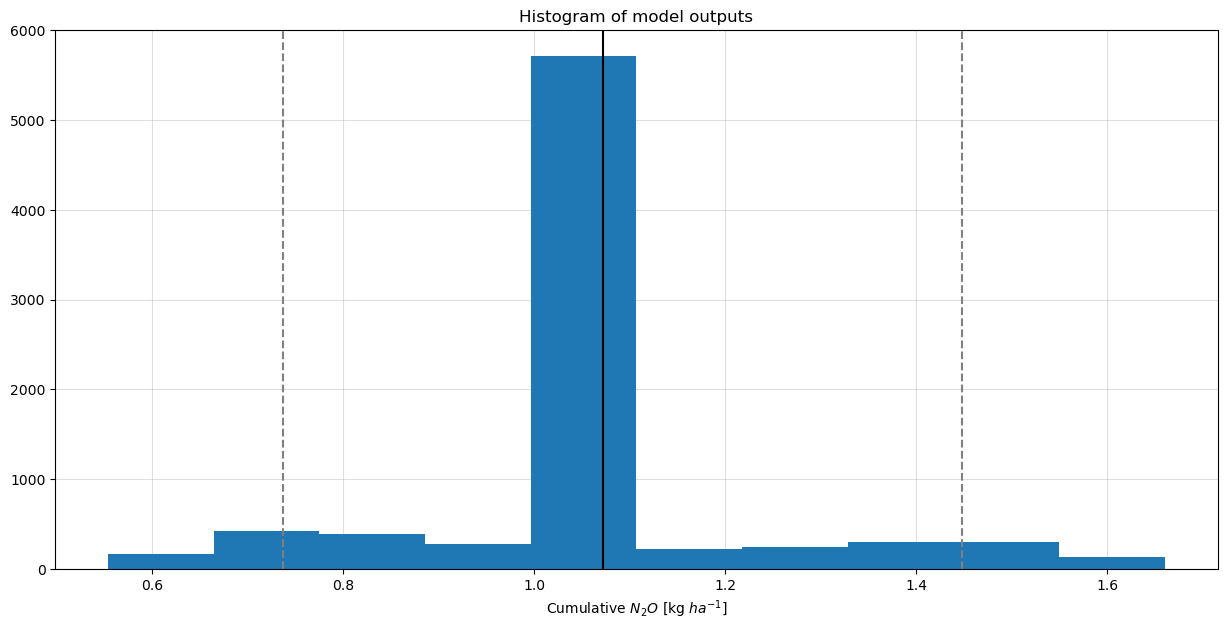

In [25]:
#Check distribution of model outputs
plt.hist(Y)
plt.title('Histogram of model outputs')
plt.xlabel('Cumulative $N_2 O$ [kg $ha^{-1}$]')
plt.axvline(x=Y.mean(), color='black')
plt.axvline(x=np.quantile(Y, 0.05), color='grey', linestyle='dashed')
plt.axvline(x=np.quantile(Y, 0.95), color='grey', linestyle='dashed')
plt.grid(alpha=0.4)

In [26]:
#Compute SI
SI = sobolanalyze.analyze(problem, Y)

In [27]:
df = pd.DataFrame({'names': problem['names'], 'S1': SI['S1'], 'S1_conf': SI['S1_conf'], 'ST': SI['ST'], 'ST_conf': SI['ST_conf']})

In [28]:
df = df.sort_values('ST', ascending=False).reset_index()
df.head()

,index,names,S1,S1_conf,ST,ST_conf
0,2,METRX_F_NIT_NO_N2O_T_EXP_1,0.226369,0.122906,0.890070,0.118867
1,1,METRX_F_DENIT_N2O_PH_2,0.059600,0.099224,0.534951,0.106334
2,0,METRX_F_DENIT_N2O_PH_1,0.163540,0.100303,0.441728,0.086637


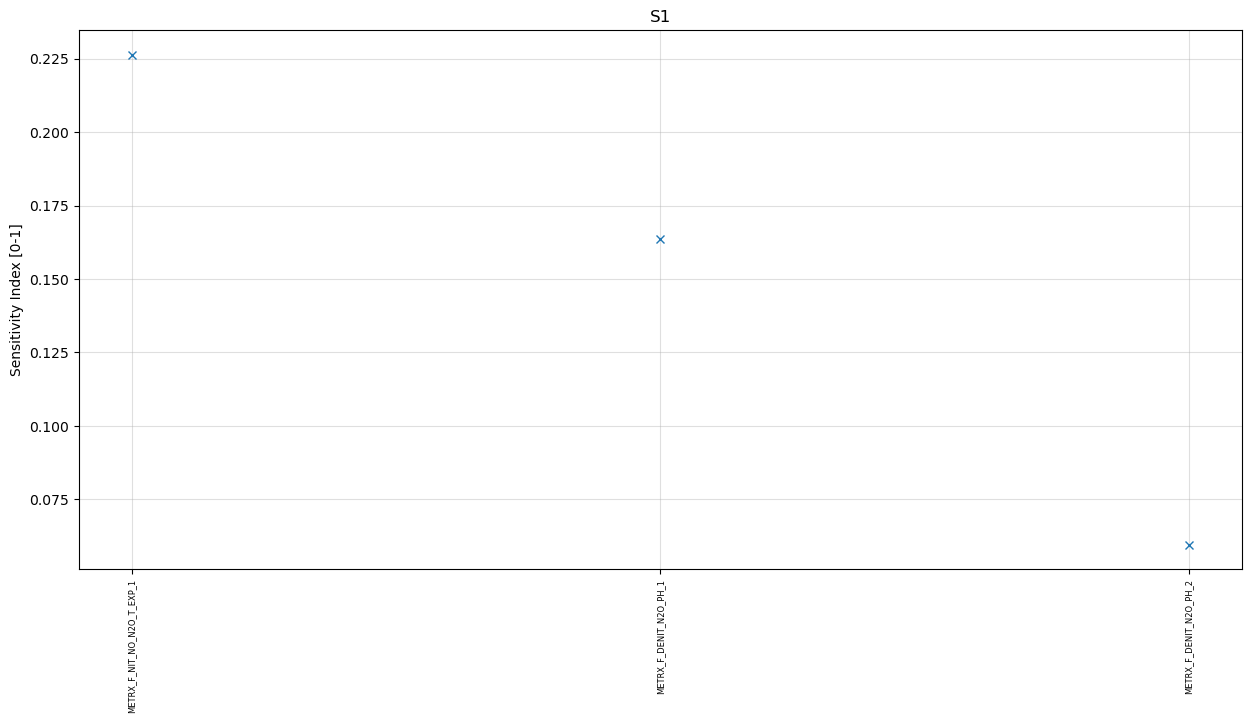

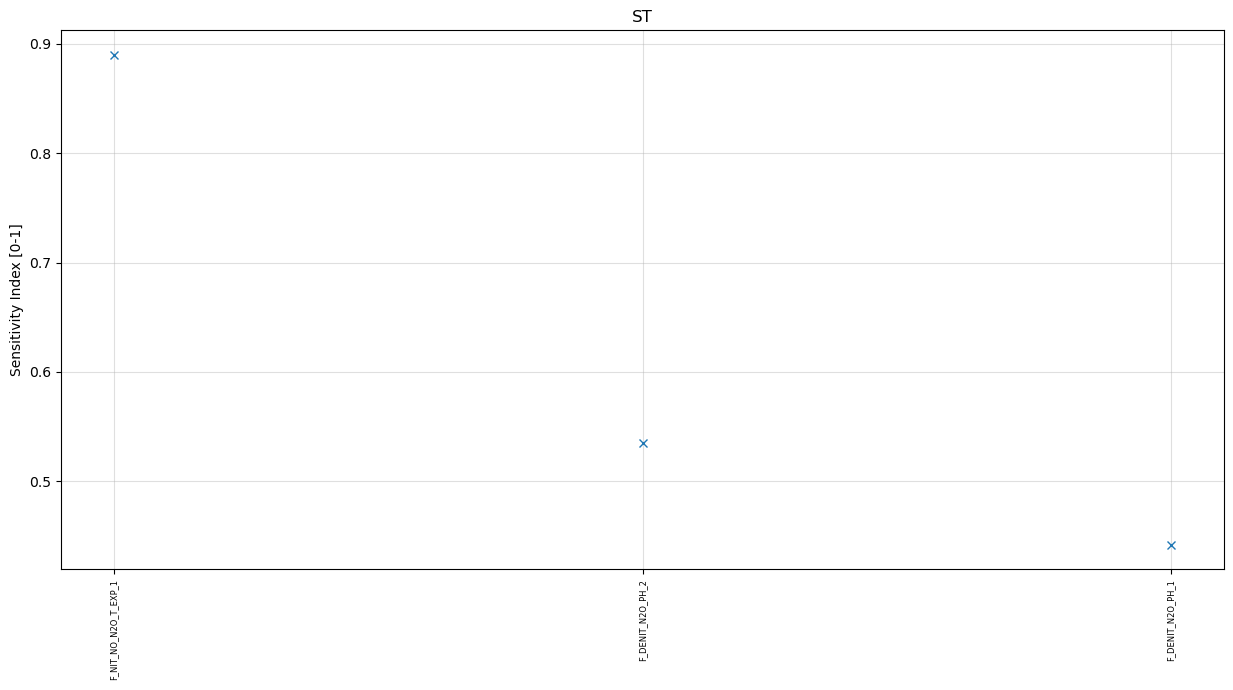

In [29]:
df_s1 = df.sort_values('S1', ascending=False).reset_index()
plt.plot([name for name in df_s1['names']], df_s1['S1'], 'x')
plt.ylabel('Sensitivity Index [0-1]')
plt.xticks(rotation=90, size=6)
plt.title('S1')
plt.grid(alpha=0.4)

plt.figure()
df_st = df.sort_values('ST', ascending=False).reset_index()
plt.plot([name[6:] for name in df_st['names']], df_st['ST'], 'x')
plt.ylabel('Sensitivity Index [0-1]')
plt.xticks(rotation=90, size=6)
plt.title('ST')
plt.grid(alpha=0.4)

In [30]:
#Set a threshold for minimum sensitivity [0, 1]
thres = 0

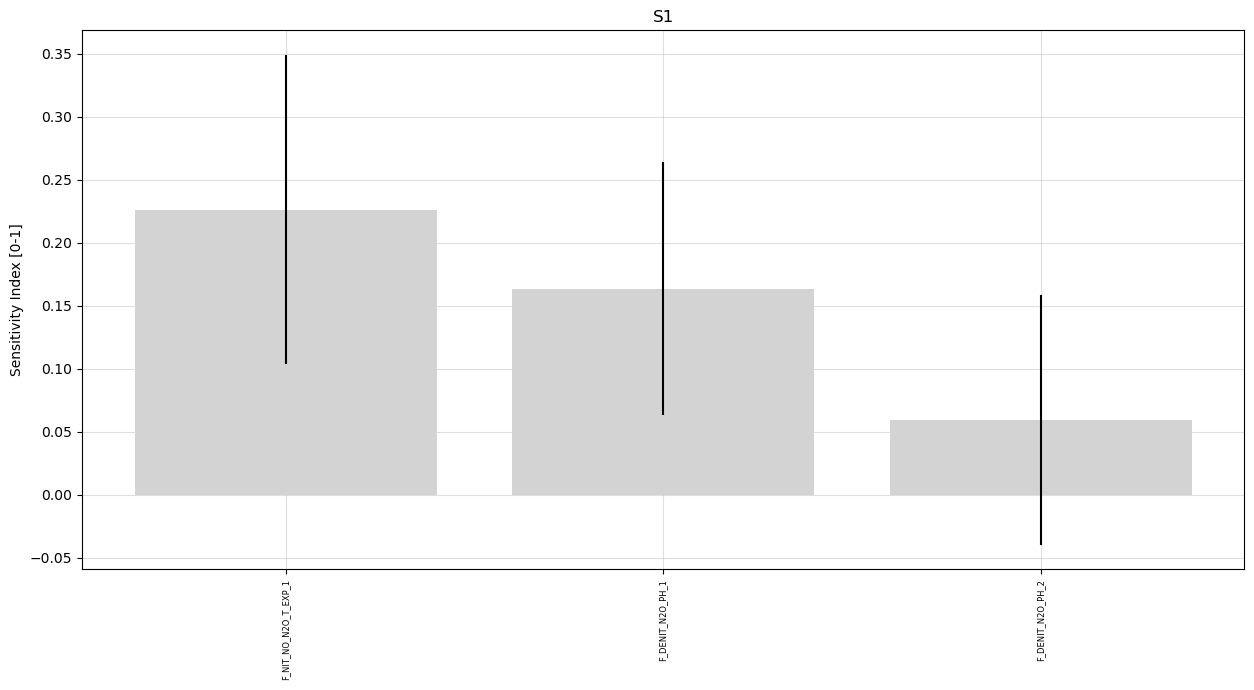

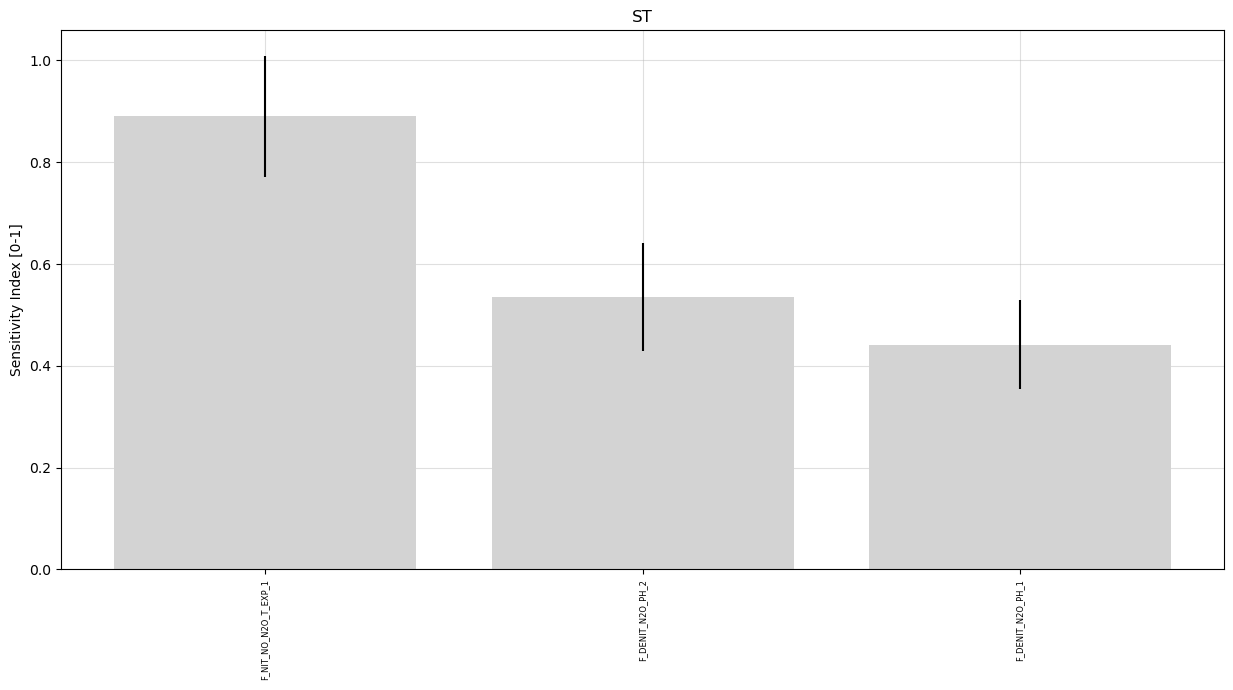

In [31]:
df_plot = df[df['ST'] > thres]

df_s1 = df_plot.sort_values('S1', ascending=False).reset_index()
plt.bar([name[6:] for name in df_s1['names']], df_s1['S1'], yerr=df_s1['S1_conf'], color='lightgrey')
plt.ylabel('Sensitivity Index [0-1]')
plt.xticks(rotation=90, size=6)
plt.title('S1')
plt.grid(alpha=0.4)

plt.figure()
df_st = df_plot.sort_values('ST', ascending=False).reset_index()
plt.bar([name[6:] for name in df_st['names']], df_st['ST'], yerr=df_st['ST_conf'], color='lightgrey')
plt.ylabel('Sensitivity Index [0-1]')
plt.xticks(rotation=90, size=6)
plt.title('ST')
plt.grid(alpha=0.4)